### Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer, LancasterStemmer, SnowballStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import wordcloud
from wordcloud import WordCloud
from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve, fbeta_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk import ngrams,bigrams,trigrams

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


### Loading the Data

In [2]:
from google.colab import files
files.upload()

Saving train.csv to train.csv


In [3]:
Data= pd.read_csv('train.csv')
Data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Understanding Data

In [4]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
Data.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
num_data=list(Data.select_dtypes(include='int').keys())
for i in num_data:
    print(Data[i].value_counts())

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


In [7]:
sent_types=Data.iloc[:,2:].sum()
sent_types

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

### Data Visualization

Text(0, 0.5, 'Count')

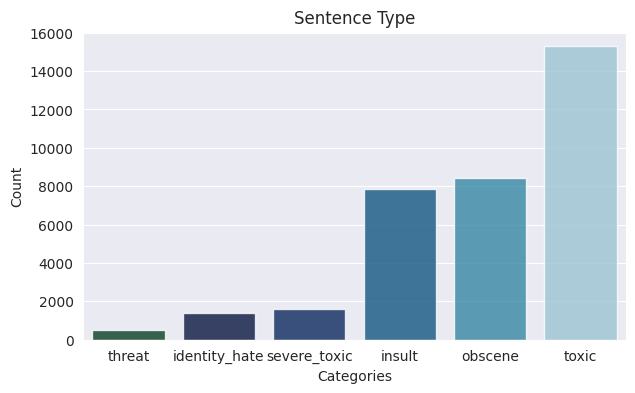

In [8]:
sns.set_style('darkgrid')
plt.figure(figsize=(7,4))
sns.barplot(x=sent_types.sort_values().index, y=sent_types.sort_values().values, alpha = 0.8, palette='ocean')
plt.title('Sentence Type')
plt.xlabel('Categories')
plt.ylabel('Count')

There are many toxic sentences followed by obscene sentence type and very few threatening sentences overall.

### Data Pre-processing

In [9]:
texts = Data['comment_text']
texts.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [10]:
stopWords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = nltk.PorterStemmer()
nltk.data.path.append("path_to_nltk_data_directory")  # Set NLTK data path

#texts = texts.astype(str) #Coverting to string
texts = texts.str.lower() #Lower case
texts = texts.apply(lambda x: re.sub(r"\n", " ", x)) #Removes \n from the text
texts = texts.apply(lambda x: [word for word in x if word not in string.punctuation]) #Removing string punctuation
texts = texts.apply(lambda x: ''.join(x)) #Joining back into sentences

In [11]:
print(texts)

0         explanation why the edits made under my userna...
1         daww he matches this background colour im seem...
2         hey man im really not trying to edit war its j...
3          more i cant make any real suggestions on impr...
4         you sir are my hero any chance you remember wh...
                                ...                        
159566    and for the second time of asking when your vi...
159567    you should be ashamed of yourself   that is a ...
159568    spitzer   umm theres no actual article for pro...
159569    and it looks like it was actually you who put ...
159570     and  i really dont think you understand  i ca...
Name: comment_text, Length: 159571, dtype: object


### Wordcloud generation

In [12]:
new=texts.astype(str)
corpus=[]
for text in new:
    tokens=nltk.word_tokenize(text) #tokenize
    lemmatized_tokens = [lemmatizer.lemmatize(i) for i in tokens] #lemmatize
    filtered_tokens= [word for word in lemmatized_tokens if not word in stopWords] #filtering stopwords
    corpus.append(TreebankWordDetokenizer().detokenize(filtered_tokens)) #append and detokenize

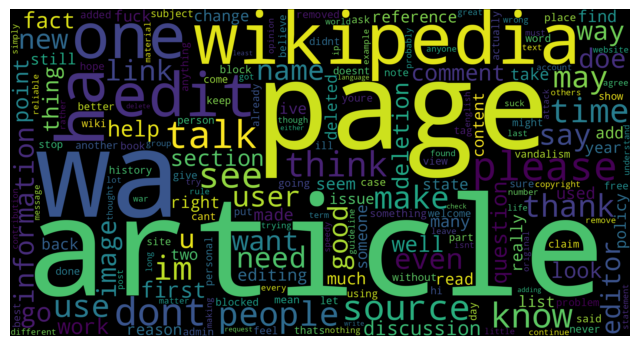

In [13]:
words=""
for row in corpus:
    for tokens in row:
        words+="".join(tokens)
wordcloud= WordCloud(collocations = False, background_color = 'black', width = 2048, height = 1080).generate(words)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Word cloud without toxic comments

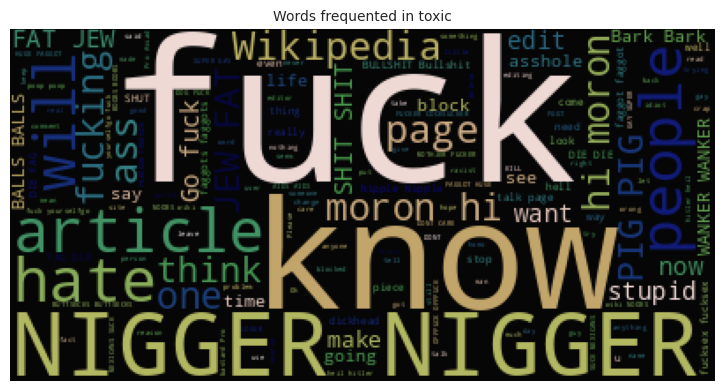

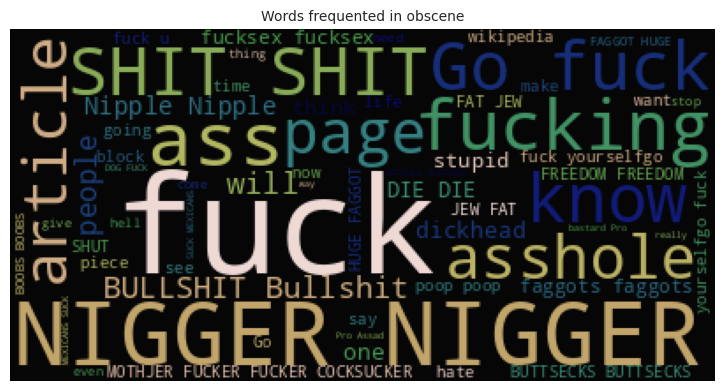

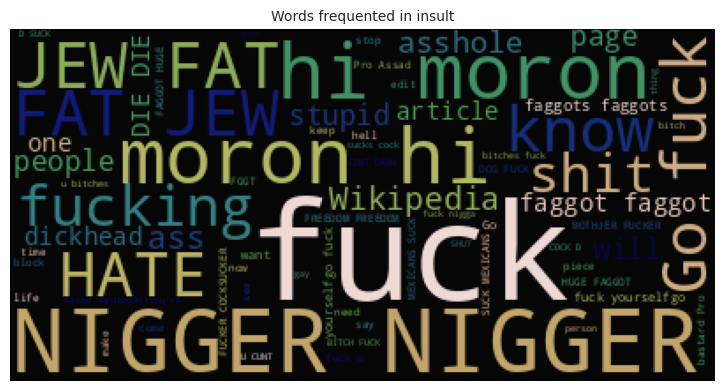

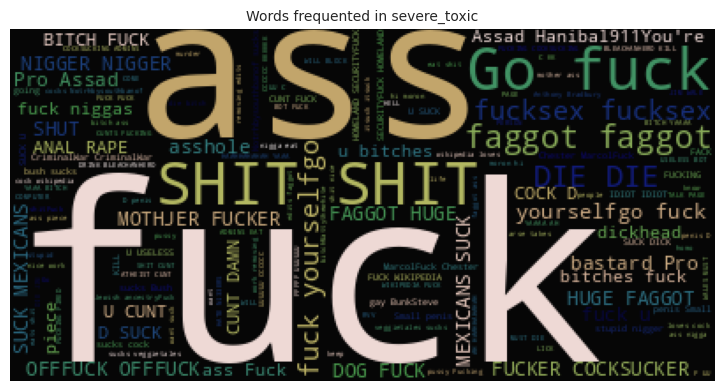

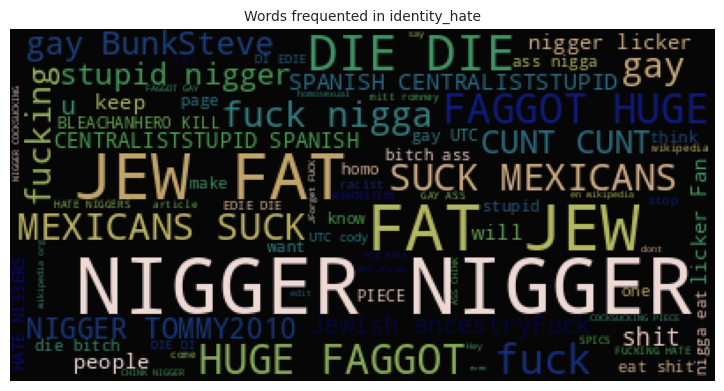

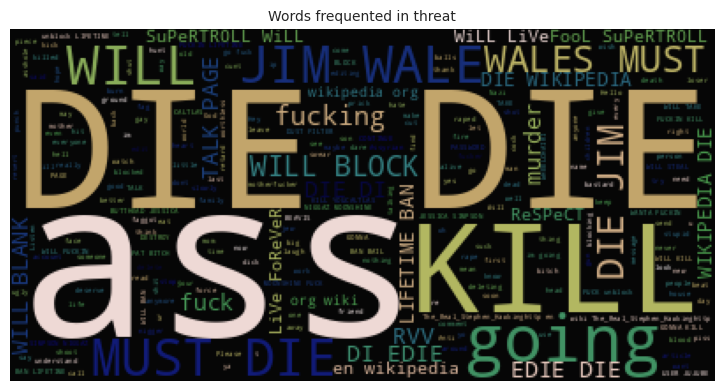

In [14]:
for i in ['toxic','obscene','insult','severe_toxic','identity_hate','threat']:
  df = Data.loc[:,['id','comment_text',i]]
  subset=df[df[i]==1]
  text=subset.comment_text.values
  wc= WordCloud(background_color="black",max_words=2000)
  wc.generate(" ".join(text))
  plt.figure(figsize=(20,20))
  plt.subplot(221)
  plt.axis("off")
  plt.title("Words frequented in {}".format(i), fontsize=10)
  plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)
# Visualising the subset datasets using wordcloud

Wordcloud with toxic comments

### Balancing Target Columns

Balancing Toxic Comments Column

In [15]:
Data['toxic'].value_counts() #Value counts of toxic comments

0    144277
1     15294
Name: toxic, dtype: int64

In [16]:
Toxic_1 = Data[Data['toxic'] == 1].iloc[0:5000,:] #Selecting only 5000 toxic comments
Toxic_0 = Data[Data['toxic'] == 0].iloc[0:5000,:] # Selecting only 5000 non toxic comments
Toxic_balanced=pd.concat([Toxic_1, Toxic_0]) #Concatenating toxic and non toxic comments
print(Toxic_balanced['toxic'].value_counts()) #Balanced column

1    5000
0    5000
Name: toxic, dtype: int64


Balancing Obscene Comments Column

In [17]:
Data['obscene'].value_counts() #Value counts of obscene comments

0    151122
1      8449
Name: obscene, dtype: int64

In [18]:
Obscene_1 = Data[Data['obscene'] == 1].iloc[0:5000,:] #Selecting only 5000 Obscene comments
Obscene_0 = Data[Data['obscene'] == 0].iloc[0:5000,:] # Selecting only 5000 Non Obscene comments
Obscene_balanced = pd.concat([Obscene_1, Obscene_0]) #Concatenating Obscene and non Obscene comments
print(Obscene_balanced['obscene'].value_counts()) #Balanced Obscene column

1    5000
0    5000
Name: obscene, dtype: int64


Balancing Insulting Comments Coulmn

In [19]:
Data['insult'].value_counts() #Value counts of insulting comments

0    151694
1      7877
Name: insult, dtype: int64

In [20]:
Insult_1 = Data[Data['insult'] == 1].iloc[0:5000,:] #Selecting only 5000 Insulting comments
Insult_0 = Data[Data['insult'] == 0].iloc[0:5000,:] # Selecting only 5000 Non Insulting comments
Insult_balanced = pd.concat([Insult_1, Insult_0]) #Concatenating Insulting and Non Insulting comments
print(Insult_balanced['insult'].value_counts()) #Balanced insult column

1    5000
0    5000
Name: insult, dtype: int64


Balancing Severe Toxic Comments Column

In [21]:
Data['severe_toxic'].value_counts() #Value counts of Severe_toxic comments

0    157976
1      1595
Name: severe_toxic, dtype: int64

In [22]:
SevereToxic_1 = Data[Data['severe_toxic'] == 1].iloc[0:1595,:] #Selecting only 1595 Severe Toxic comments
SevereToxic_0 = Data[Data['severe_toxic'] == 0].iloc[0:1595,:] # Selecting only 1595 Non Severe Toxic comments
SevereToxic_balanced = pd.concat([SevereToxic_1, SevereToxic_0]) #Concatenating Severe Toxic and Non Severe Toxic comments
print(SevereToxic_balanced['severe_toxic'].value_counts()) #Balanced severe toxic column

1    1595
0    1595
Name: severe_toxic, dtype: int64


Balancing Identity Hate Comments Column

In [23]:
Data['identity_hate'].value_counts() #Value counts of Identity hate comments

0    158166
1      1405
Name: identity_hate, dtype: int64

In [24]:
IdentityHate_1 = Data[Data['identity_hate'] == 1].iloc[0:1405,:] #Selecting only 1405 Identity Hate comments
IdentityHate_0 = Data[Data['identity_hate'] == 0].iloc[0:1405,:] # Selecting only 1405 Non Identity Hate comments
IdentityHate_balanced = pd.concat([IdentityHate_1, IdentityHate_0]) #Concatenating Identity Hate and Non Identity Hate comments
print(IdentityHate_balanced['identity_hate'].value_counts()) #Balanced identity_hate column

1    1405
0    1405
Name: identity_hate, dtype: int64


Balancing Threatening Comments Column

In [25]:
Data['threat'].value_counts() #Value counts of threatening comments

0    159093
1       478
Name: threat, dtype: int64

In [26]:
Threat_1 = Data[Data['threat'] == 1].iloc[0:478,:] #Selecting only 1405 Threatening comments
Threat_0 = Data[Data['threat'] == 0].iloc[0:478,:] # Selecting only 1405 Threatening comments
Threat_balanced = pd.concat([Threat_1, Threat_0]) #Concatenating Threatening and Non Threatening comments
print(Threat_balanced['threat'].value_counts()) #Balanced Threatening column

1    478
0    478
Name: threat, dtype: int64


### Model Fitting and Evaluation

In [42]:
for data in [Toxic_balanced, Obscene_balanced, Insult_balanced, SevereToxic_balanced, IdentityHate_balanced, Threat_balanced]:
  if data is Toxic_balanced:
    label='toxic'
  elif data is Obscene_balanced:
    label='obscene'
  elif data is Insult_balanced:
    label='insult'
  elif data is SevereToxic_balanced:
    label='severe_toxic'
  elif data is IdentityHate_balanced:
    label='identity_hate'
  else:
    label='threat'

  # Split the data into X and y data sets
  X = data.comment_text
  Y = data[label]

  # Split our data into training and test data
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=50)

  # Using vectorizer and removing stopwords
  cv = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

  # Transforming x-train and x-test
  X_train = cv.fit_transform(X_train)
  X_test  = cv.transform(X_test)

  ## Machine learning models
  lr = LogisticRegression().fit(X_train, Y_train)   ## Logistic regression
  knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train)   ## k-nearest neighbours
  bnb = BernoulliNB().fit(X_train, Y_train)    ## BernoulliNaive Bayes
  mnb = MultinomialNB().fit(X_train, Y_train)    ## Multinomial naive bayes
  svc = LinearSVC().fit(X_train, Y_train)    ## Support vector machine
  rf = RandomForestClassifier(n_estimators=100, random_state=50).fit(X_train, Y_train)    ## Random Forest

  ## Model Evaluation
  f1_score_train = {'F1 Score for:  Train data': [f1_score(lr.predict(X_train), Y_train), f1_score(knn.predict(X_train), Y_train), f1_score(bnb.predict(X_train), Y_train),
                                 f1_score(mnb.predict(X_train), Y_train), f1_score(svc.predict(X_train), Y_train), f1_score(rf.predict(X_train), Y_train)]}

  f1_score_test= {'     Test data ' :[f1_score(lr.predict(X_test), Y_test), f1_score(knn.predict(X_test), Y_test), f1_score(bnb.predict(X_test), Y_test),
                                 f1_score(mnb.predict(X_test), Y_test), f1_score(svc.predict(X_test), Y_test), f1_score(rf.predict(X_test), Y_test)]}
  ## Saving f1 score results into a dataframe
  df1 = pd.DataFrame(f1_score_train, index=['Logistic Regression','KNN Classifier', 'Bernoulli Naiive Bayes', 'Multinomial Naiive Bayes', 'Support Vector Classifier', 'Random Forest Classifier'])


  df2 = pd.DataFrame(f1_score_test, index=['Logistic Regression','KNN Classifier', 'Bernoulli Naiive Bayes', 'Multinomial Naiive Bayes', 'Support Vector Classifier', 'Random Forest Classifier'])

  result_df = pd.concat([df1, df2], axis=1)
  print(label.upper())
  print(result_df)
  print('--------------------------------------------')

TOXIC
                           F1 Score for:  train data     test data 
Logistic Regression                         0.948755       0.861188
KNN Classifier                              0.994172       0.752418
Bernoulli Naiive Bayes                      0.811314       0.756197
Multinomial Naiive Bayes                    0.947505       0.872973
Support Vector Classifier                   0.997434       0.866142
Random Forest Classifier                    0.999715       0.841360
--------------------------------------------
OBSCENE
                           F1 Score for:  train data     test data 
Logistic Regression                         0.958876       0.900662
KNN Classifier                              0.678371       0.672534
Bernoulli Naiive Bayes                      0.815887       0.764882
Multinomial Naiive Bayes                    0.949836       0.886243
Support Vector Classifier                   0.998144       0.911825
Random Forest Classifier                    0.999857     

We can see that overall we have highest scores for Logistic Regression model followed by Support Vector Classifier model and then Random Forest Classifier. The other models have high scores for some types of comments while for others it does not have very good scores.

### Testing the model with toxic comment

In [43]:
X = Toxic_balanced.comment_text
Y = Toxic_balanced['toxic']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

# Initiate a Tfidf vectorizer
CV = TfidfVectorizer(ngram_range=(1,1), stop_words='english')
X_train = CV.fit_transform(X_train)
X_test = CV.transform(X_test)

## Logistic regression
lr = LogisticRegression().fit(X_train, Y_train)
lr.predict(X_test)
## Multinomial naive bayes
mnb = MultinomialNB().fit(X_train, Y_train)
mnb.predict(X_test)
## Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=50).fit(X_train, Y_train)
rf.predict(X_test)

array([0, 1, 1, ..., 1, 1, 1])

In [44]:
comment1 = ['i killed an insect and ate it']
comment1 = CV.transform(comment1)
print(lr.predict_proba(comment1)[:,1])
print(mnb.predict_proba(comment1)[:,1])
print(rf.predict_proba(comment1)[:,1])

[0.49390751]
[0.46797879]
[0.8145]


According to our model prediction for the comment1, we can see that the Logistic Regression model predicts the comment to be 49% toxic, Multinomial Bayes Model predicts the comment to be 46% toxic and the Random Forest classifier predicts the comment to be 81% toxic.

In [45]:
comment2 = ['Is this sentence a good one']
comment2 = CV.transform(comment2)
print(lr.predict_proba(comment2)[:,1])
print(mnb.predict_proba(comment2)[:,1])
print(rf.predict_proba(comment2)[:,1])

[0.21159557]
[0.21816445]
[0.125]



For comment 2, we can see that the Logistic Regression model predicts the comment to be 21% toxic, Multinomial Bayes Model predicts the comment to be 21% toxic and the Random Forest classifier predicts the comment to be 12% toxic.

In [46]:
comment3 = ['truth will prevail']
comment3 = CV.transform(comment3)
print(lr.predict_proba(comment3)[:,1])
print(mnb.predict_proba(comment3)[:,1])
print(rf.predict_proba(comment3)[:,1])

[0.51060662]
[0.50895161]
[0.61964286]


In the last comment, we see that the Logistic Regression model predicts the comment to be 51% toxic, Multinomial Bayes Model predicts the comment to be 50% toxic and the Random Forest classifier predicts the comment to be 61% toxic.

It solely depends on the analyst's interest and preference to select which model among these. The accuracy of these three models are considerable and can be used further for analysing the data but I would have chosen Random Forest Classifier since it provides better accuracy for the non-toxic comments like comment 2.